In [1]:
# import necessary libraries
#!pip install ase
from ase.io import read
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
# Load the files and save our structural info as variables
file_path_rotated="/content/H2O_rotated.xyz"
file_path_unrotated="/content/H2O_unrotated.xyz"

ftrs_rotated=read(os.getcwd()+file_path_rotated,':')
ftrs_unrotated=read(os.getcwd()+file_path_unrotated,':')

nsample=len(ftrs_rotated)
natom=[ftrs_rotated[i].get_global_number_of_atoms() for i in range(nsample)]
#coords=np.array([ftrs_rotated[i].get_positions() for i in range(nsample)])
#dists=np.array([ftrs[i].get_all_distances() for i in range(nsample)])

all_labels=[ftrs_rotated[i].get_chemical_symbols() for i in range(nsample)]

dists_rotated = np.zeros((nsample,3))


for i in range(nsample):

    dists_rotated[i,0] = ftrs_rotated[i].get_distance(0,1)
    dists_rotated[i,1] = ftrs_rotated[i].get_distance(1,2)
    dists_rotated[i,2] = ftrs_rotated[i].get_distance(0,2)
dists_unrotated = np.zeros((nsample,3))


for i in range(nsample):

    dists_unrotated[i,0] = ftrs_unrotated[i].get_distance(0,1)
    dists_unrotated[i,1] = ftrs_unrotated[i].get_distance(1,2)
    dists_unrotated[i,2] = ftrs_unrotated[i].get_distance(0,2)
    
    
    
    
# read the corresponding energy values
ener_rotated=np.loadtxt(os.getcwd()+"/content/H2O_rotated.ener")
ener_unrotated=np.loadtxt(os.getcwd()+"/content/H2O_unrotated.ener")

C:\Users\stephen\AppData\Roaming\Python\Python39\site-packages\ase\atoms.py:967: VisibleDeprecationWarning: Use get_global_number_of_atoms() instead
  warnings.warn('Use get_global_number_of_atoms() instead',


In [3]:
#normalize inputs
norm_dists_rotated=np.zeros((dists_rotated.shape))
norm_dists_unrotated=np.zeros((dists_unrotated.shape))

#for a in range(natom[0]):
for j in range(3):
    
    norm_dists_rotated[:,j] = (dists_rotated[:,j] - np.mean(dists_rotated[:,j]))/(np.max(dists_rotated[:,j]) - np.min(dists_rotated[:,j]))
    norm_dists_unrotated[:,j] = (dists_unrotated[:,j] - np.mean(dists_unrotated[:,j]))/(np.max(dists_unrotated[:,j]) - np.min(dists_unrotated[:,j]))
norm_E_rotated = (ener_rotated - np.mean(ener_rotated))/(np.max(ener_rotated) - np.min(ener_rotated))
norm_E_unrotated = (ener_unrotated - np.mean(ener_unrotated))/(np.max(ener_unrotated) - np.min(ener_unrotated))


In [4]:
# build and compile the model
def build_compile_model(natom, reg, learn_rate):
    model = keras.Sequential()
    #specify an input layer with the number of nodes = the number of relative distances
    #model.add(layers.Input(shape=(natom,3)))

    #flatten the 2D input array into a 1D array, you can also do this with numpy .flatten()
    model.add(layers.Flatten(input_shape=(natom,1)))

    #add hidden layers
    #model.add(layers.Dense(64, activation='sigmoid', kernel_regularizer=keras.regularizers.l2(reg), bias_regularizer=keras.regularizers.l2(reg)))
    
    model.add(layers.Dense(32, activation='sigmoid', kernel_regularizer=keras.regularizers.l2(reg), bias_regularizer=keras.regularizers.l2(reg)))
    model.add(layers.Dense(16, activation='sigmoid', kernel_regularizer=keras.regularizers.l2(reg), bias_regularizer=keras.regularizers.l2(reg)))
    model.add(layers.Dense(8, activation='sigmoid', kernel_regularizer=keras.regularizers.l2(reg), bias_regularizer=keras.regularizers.l2(reg)))

    #finally, add an output layer
    model.add(layers.Dense(1, use_bias=False,kernel_regularizer=keras.regularizers.l2(reg)))

    # define the optimizer: Adam is a gradient descent algorithm 
    opt=keras.optimizers.Adam(learning_rate=learn_rate)

    #compile the model
    model.compile(loss='mse',optimizer=opt)

    return model

model = build_compile_model(3, 1e-9, 1e-2)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3)                 0         
                                                                 
 dense (Dense)               (None, 32)                128       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 1)                 8         
                                                                 
Total params: 800
Trainable params: 800
Non-trainable params: 0
_________________________________________________________________


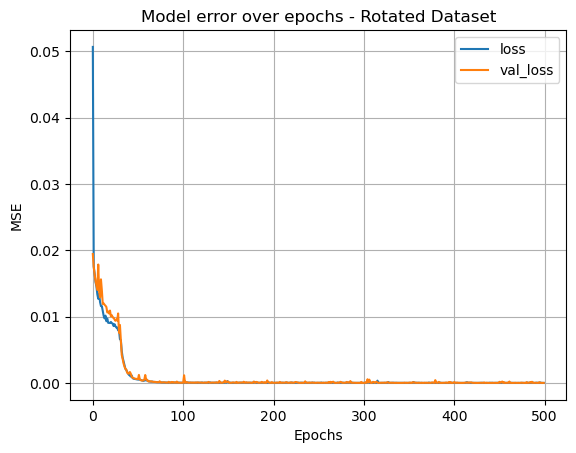

In [5]:
# run the model for the rotated dataset and plot the error over time
idx=np.arange(nsample)
np.random.shuffle(idx)

tr_dists_rotated=norm_dists_rotated[idx[:1250],:]
tr_E_rotated=norm_E_rotated[idx[:1250]]
va_dists_rotated=norm_dists_rotated[idx[1250:1500],:]
va_E_rotated=norm_E_rotated[idx[1250:1500]]
te_dists_rotated=norm_dists_rotated[idx[1500:],:]
te_E_rotated=ener_rotated[idx[1500:]]


history=model.fit(tr_dists_rotated,tr_E_rotated,epochs=500,validation_data=(va_dists_rotated,va_E_rotated),verbose=0)

# plot a learning curve of loss of the training and validation set vs the number of epochs the model is trained
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Model error over epochs - Rotated Dataset')
plt.legend()
plt.grid(True)
plt.show()


8/8 [==============================] - 1s 3ms/step
The model's RMSE is:  0.00527489163672273


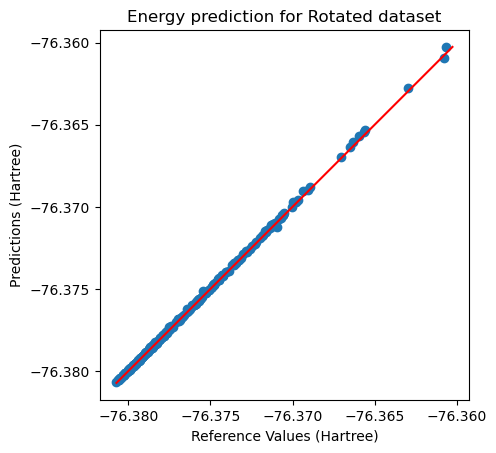

In [6]:
# plot the predictions for the test set

norm_predict_rotated=model.predict(te_dists_rotated)
predict_rotated=norm_predict_rotated*(np.max(ener_rotated) - np.min(ener_rotated))+np.mean(ener_rotated)
rmse_rotated = np.sqrt(np.mean((predict_rotated-te_E_rotated)**2))

print("The model's RMSE is: ", rmse_rotated)
#visualize the model's prediction vs the correct value
plt.axes(aspect='equal')
plt.scatter(te_E_rotated, predict_rotated)
plt.xlabel('Reference Values (Hartree)')
plt.ylabel('Predictions (Hartree)')
plt.title('Energy prediction for Rotated dataset')
plt.plot([np.min([np.min(te_E_rotated),np.min(predict_rotated)]),np.max([np.max(te_E_rotated),np.max(predict_rotated)])], [np.min([np.min(te_E_rotated),np.min(predict_rotated)]),np.max([np.max(te_E_rotated),np.max(predict_rotated)])], 'r-')
plt.show()

Now, let's run it for the unrotated dataset. 

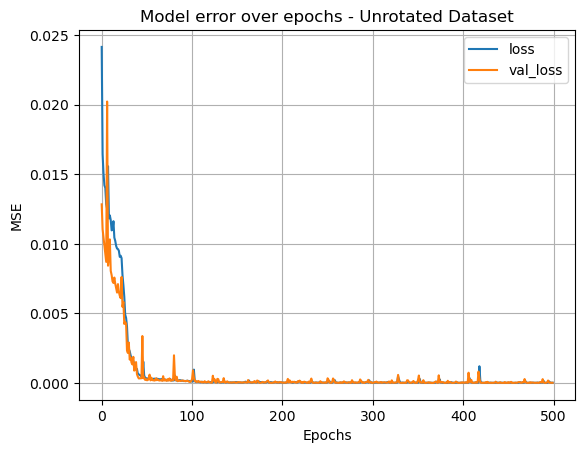

In [7]:
# run the model for the unrotated dataset and plot the error over time
model = build_compile_model(3, 1e-9, 1e-2)
idx=np.arange(nsample)
np.random.shuffle(idx)
tr_dists_unrotated=norm_dists_unrotated[idx[:1250],:]
tr_E_unrotated=norm_E_unrotated[idx[:1250]]
va_dists_unrotated=norm_dists_unrotated[idx[1250:1500],:]
va_E_unrotated=norm_E_unrotated[idx[1250:1500]]
te_dists_unrotated=norm_dists_unrotated[idx[1500:],:]
te_E_unrotated=ener_unrotated[idx[1500:]]


history=model.fit(tr_dists_unrotated,tr_E_unrotated,epochs=500,validation_data=(va_dists_unrotated,va_E_unrotated),verbose=0)

# plot a learning curve of loss of the training and validation set vs the number of epochs the model is trained
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Model error over epochs - Unrotated Dataset')
plt.legend()
plt.grid(True)
plt.show()

8/8 [==============================] - 0s 2ms/step
The model's RMSE is:  0.005216168212366768


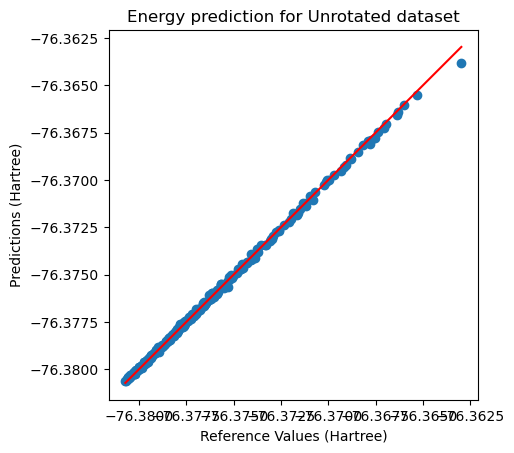

In [8]:
# plot the predictions for the test set

norm_predict_unrotated=model.predict(te_dists_unrotated)
predict_unrotated=norm_predict_unrotated*(np.max(ener_unrotated) - np.min(ener_unrotated))+np.mean(ener_unrotated)
rmse_unrotated = np.sqrt(np.mean((predict_unrotated-te_E_unrotated)**2))

print("The model's RMSE is: ", rmse_unrotated)
#visualize the model's prediction vs the correct value
plt.axes(aspect='equal')
plt.scatter(te_E_unrotated, predict_unrotated)
plt.xlabel('Reference Values (Hartree)')
plt.ylabel('Predictions (Hartree)')
plt.title('Energy prediction for Unrotated dataset')
plt.plot([np.min([np.min(te_E_unrotated),np.min(predict_unrotated)]),np.max([np.max(te_E_unrotated),np.max(predict_unrotated)])], [np.min([np.min(te_E_unrotated),np.min(predict_unrotated)]),np.max([np.max(te_E_unrotated),np.max(predict_unrotated)])], 'r-')
plt.show()